### Please do not use this.
I copied and pasted a bunch of stuff and it might be inconsistent with the actual experiment, be cautious if using it.

In [1]:
import os

import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import flax.serialization
import msgpack
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from jax_snn.models import SimpleResRNN

In [19]:
files = {
    'BRF': f'../jax_experiments/smnist/runs/permuted_brf.csv',
    # 'RF': f'jax_experiments/smnist/runs/rf.csv',
    'ALIF': f'../experiments/smnist/runs/alif_tbptt_permuted.csv'
}


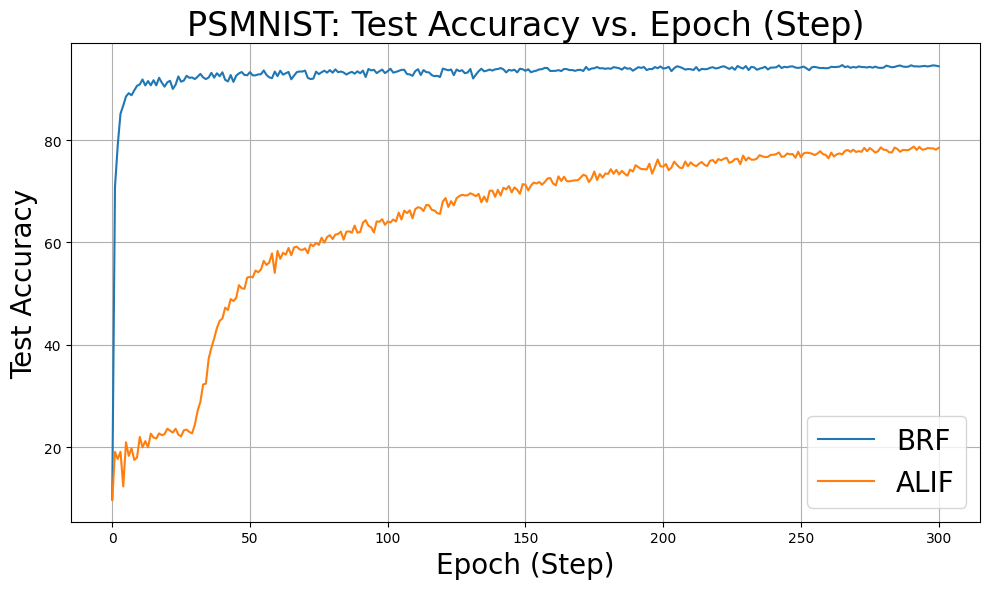

In [21]:
def plot_acc_curve():
    plt.figure(figsize=(10, 6))

    for label, file in files.items():
        df = pd.read_csv(file)
        plt.plot(df['Step'], df['Value'], label=f'{label}')


    plt.title(f'PSMNIST: Test Accuracy vs. Epoch (Step)', fontsize=24)
    plt.xlabel('Epoch (Step)', fontsize=20)
    plt.ylabel('Test Accuracy', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(fname="result", dpi=300, bbox_inches='tight')
    plt.show()

plot_acc_curve()


In [2]:
init_file = f'../smnist/models/permuted_brf/init.msgpack'
trained_file = f'../smnist/models/permuted_brf/final.msgpack'
# Constants
DELTA = 0.01  # Time step from the paper


In [3]:
def load_params_from_msgpack(model: nn.Module, msgpack_path: str, input_shape):
    """Load serialized Flax model parameters from .msgpack"""
    dummy_input = jnp.zeros(input_shape)
    variables = model.init(jax.random.PRNGKey(0), dummy_input)
    empty_params = variables['params']

    with open(msgpack_path, 'rb') as f:
        packed = f.read()
    loaded_params = flax.serialization.from_bytes(empty_params, packed)
    return loaded_params

In [4]:

def extract_brf_params(params):
    """Extract omega and b_offset from a Flax parameter PyTree"""
    extracted = {}

    def traverse(tree, prefix=""):
        for k, v in tree.items():
            if isinstance(v, dict):
                traverse(v, prefix + k + "/")
            else:
                if "omega" in k:
                    extracted["omega"] = np.array(v)
                elif "b_offset" in k or "b_" in k:
                    extracted["b_offset"] = np.array(v)

    traverse(params)
    return extracted

In [5]:

input_size=1
output_size=10
hidden_size = 256
mask_prob = 0.0
omega_a = 15.
omega_b = 85.
b_offset_a = 0.1
b_offset_b = 1.
out_adaptive_tau_mem_mean = 20.
out_adaptive_tau_mem_std = 1.
output_bias = False

model = SimpleResRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    adaptive_omega_a=omega_a,
    adaptive_omega_b=omega_b,
    adaptive_b_offset_a=b_offset_a,
    adaptive_b_offset_b=b_offset_b,
    out_adaptive_tau_mem_mean=out_adaptive_tau_mem_mean,
    out_adaptive_tau_mem_std=out_adaptive_tau_mem_std,
    output_bias=output_bias,
)


In [6]:
input_shape=(28*28,256, model.input_size)

In [7]:
init_params = load_params_from_msgpack(model, init_file, input_shape)
init_brf_params = extract_brf_params(init_params)
trained_params = load_params_from_msgpack(model, trained_file, input_shape)
trained_brf_params = extract_brf_params(trained_params)

/home/henry/school/brf-neurons/jax_experiments/figures


In [8]:
def calculate_b_c(omega, b_offset):
    """Calculate b_c = p(ω) - b' using divergence boundary formula"""
    p_omega = (-1 + np.sqrt(1 - (DELTA * omega)**2)) / DELTA
    return p_omega - b_offset


In [9]:
init_b_c = calculate_b_c(init_brf_params['omega'], init_brf_params['b_offset'])
trained_b_c = calculate_b_c(trained_brf_params['omega'], trained_brf_params['b_offset'])


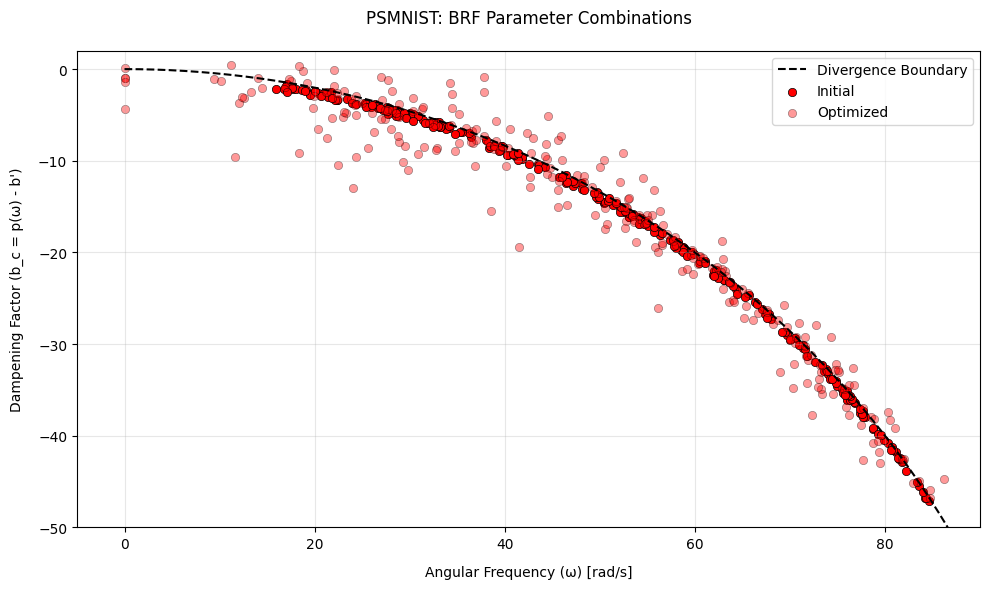

In [10]:
plt.figure(figsize=(10, 6))

# Plot divergence boundary first (background)
omega_range = np.linspace(0, 90, 800)
boundary = (-1 + np.sqrt(1 - (DELTA * omega_range)**2)) / DELTA
plt.plot(omega_range, boundary, 'k--', label='Divergence Boundary', linewidth=1.5)

# Plot parameters with different transparency
plt.scatter(init_brf_params['omega'], init_b_c,
            c='red', alpha=1, label='Initial', edgecolors='black', linewidths=0.5)
plt.scatter(trained_brf_params['omega'], trained_b_c,
            c='red', alpha=0.4, label='Optimized', edgecolors='black', linewidths=0.5)


plt.title(f'PSMNIST: BRF Parameter Combinations', pad=20)
plt.xlabel('Angular Frequency (ω) [rad/s]', labelpad=10)
plt.ylabel("Dampening Factor (b_c = p(ω) - b')", labelpad=10)
plt.grid(True, alpha=0.3)
plt.legend()


plt.xlim(-5, 90)
plt.ylim(-50, 2)  # b_c should be negative

plt.tight_layout()
plt.savefig(f'frequency_plot.png', dpi=300, bbox_inches='tight')
plt.show()